## Importing Libraries

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
from typing import Callable
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Loss function

In [8]:
class MSE:
  def __call__(self, pred_y, true_y):
    self.pred_y = pred_y
    self.true_y = true_y
    return tf.reduce_mean((pred_y-true_y)**2)
  
  def backward(self):
    n = self.true_y.shape[0]
    self.gradient = 2.0 * (self.pred_y - self.true_y) / n
    return self.gradient

## Linear Layer

In [9]:
class Linear:
  def __init__(self, input_dim: int, num_hidden:int = 1):
    self.weights = tf.Variable(tf.random.uniform(shape=(input_dim, num_hidden)))
    self.bias = tf.Variable(tf.zeros(shape=(num_hidden, )))

  def __call__(self, X):
    self.X = X
    output = tf.matmul(self.X, self.weights) + self.bias
    return output
  
  def backward(self, gradient):
    self.weights_gradient = tf.matmul(self.X, gradient, transpose_a=True) #matrix multiplication of X.T * gradient
    self.bias_gradient = tf.reduce_sum(gradient, 0)
    self.X_gradient = tf.matmul(gradient, self.weights, transpose_b=True)
    return self.X_gradient

  def update(self, learning_rate):
    self.weights = tf.Variable(self.weights - learning_rate * self.weights_gradient)
    self.bias = tf.Variable(self.bias - learning_rate * self.bias_gradient)

## Relu Function

In [10]:
class Relu:
  def __call__(self, input_):
    self.input_ = input_
    self.output = tf.clip_by_value(self.input_, 0, tf.float32.max)
    return self.output

  def backward(self, output_gradient):
    self.input_gradient = tf.cast((self.input_ > 0), tf.float32) * output_gradient
    return self.input_gradient

## Defining model

In [11]:
class Model:
  def __init__(self, input_dim, num_hidden):
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu = Relu()
    self.linear2 = Linear(num_hidden, 2)

  def __call__(self, X):
    l1 = self.linear1(X)
    r = self.relu(l1)
    l2 = self.linear2(r)
    return l2

  def backward(self, output_gradient):
    linear2_gradient = self.linear2.backward(output_gradient)
    relu_gradient = self.relu.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu_gradient)
    return linear1_gradient

  def update(self, learning_rate):
    self.linear2.update(learning_rate)
    self.linear1.update(learning_rate)

## Fitting the model

In [12]:
def fit(X, y, model:Callable, loss:Callable, learning_rate:float, num_epochs):
  for epoch in range(num_epochs):
    pred_y = model(X)
    loss_value = loss(pred_y, y)
    if epoch % 5 == 0:
      print(f'Epoch: {epoch}, Loss: {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(learning_rate)

## Generating Data

In [13]:
no_samples, input_dim, output_dim, learning_rate = 500, 3, 2, 0.01 
X = tf.random.uniform((no_samples, input_dim), -1, 1)

weights_true = tf.transpose(tf.constant([[6, 1, 8],[-3, 1, 3]], dtype=tf.float32))
bias_true = tf.constant([[0.5], [1]], dtype=tf.float32)
true_y = tf.matmul(X ** 2, weights_true) + tf.matmul(X, weights_true) + tf.transpose(bias_true)
print(f'X:{X.shape}, y:{true_y.shape}, weights:{weights_true.shape}, bias:{bias_true.shape}')

X:(500, 3), y:(500, 2), weights:(3, 2), bias:(2, 1)


## Plotting the data

In [14]:
def plot_3d(title, X, y, y_pred=None):
  X_tnse = TSNE(n_components=2, random_state=123).fit_transform(X)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_tnse[:,0], X_tnse[:,1], y, label='y_true')
  ax.set_title(title)
  if y_pred is not None:
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred, label='y_pred', marker='v')
  plt.legend()
  plt.show()

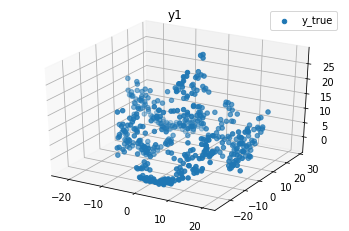

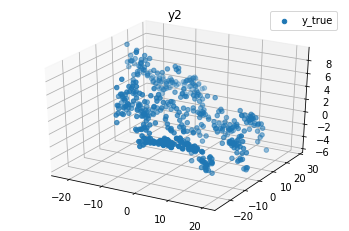

In [15]:
plot_3d('y1', X, true_y[:,0])
plot_3d('y2', X, true_y[:,1])

## Running the model

Loss value: 28.795724868774414


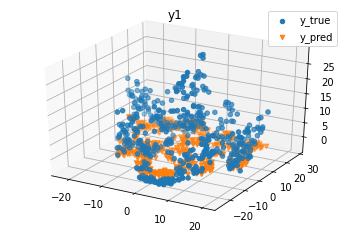

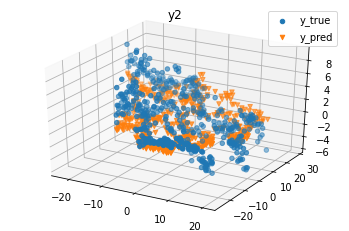

In [16]:
#running the model for 1 cycle

loss = MSE()
model = Model(input_dim, 10)
pred_y = model(X)
loss_value = loss(pred_y, true_y)
loss_gradient = loss.backward()
print(f'Loss value: {loss_value}')
model.backward(loss_gradient)
plot_3d('y1', X, true_y[:, 0], pred_y[:, 0])
plot_3d('y2', X, true_y[:, 1], pred_y[:, 1])

Epoch: 0, Loss: 28.795724868774414
Epoch: 5, Loss: 17.580568313598633
Epoch: 10, Loss: 10.395021438598633
Epoch: 15, Loss: 7.852667808532715
Epoch: 20, Loss: 6.794215679168701
Epoch: 25, Loss: 6.110100269317627
Epoch: 30, Loss: 5.573247909545898
Epoch: 35, Loss: 5.116028785705566
Epoch: 40, Loss: 4.719833850860596
Epoch: 45, Loss: 4.3611650466918945
Epoch: 50, Loss: 4.032958507537842
Epoch: 55, Loss: 3.7317466735839844
Epoch: 60, Loss: 3.4584076404571533
Epoch: 65, Loss: 3.2156054973602295
Epoch: 70, Loss: 2.997469663619995
Epoch: 75, Loss: 2.8026764392852783
Epoch: 80, Loss: 2.6297943592071533
Epoch: 85, Loss: 2.4748895168304443
Epoch: 90, Loss: 2.3362135887145996
Epoch: 95, Loss: 2.2102391719818115


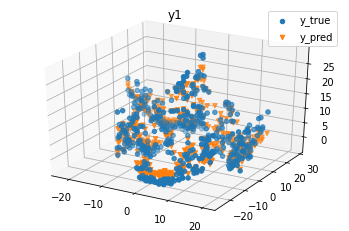

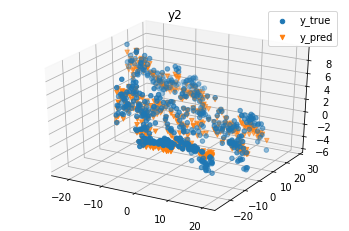

In [17]:
#running for 100 epochs
fit(X, true_y, model=model, loss=loss, learning_rate=learning_rate, num_epochs=100)
pred_y = model(X)
plot_3d('y1', X, true_y[:, 0], pred_y[:, 0])
plot_3d('y2', X, true_y[:, 1], pred_y[:, 1])